# Cart-Pole with Pixels

In [1]:
# Boolean value to check if we are in colab or not
colab = False 
show_video = False
show_render = False
laod_good_model = True

In [2]:
if colab:
    !pip install gym
else:
    %pip install gym

Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F
import os
from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

#import opencv
import cv2

#use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

#create a folder called training
if not os.path.exists('training'):
    os.makedirs('training')

In [4]:
if colab:
    !apt update
    !apt-get install python-opengl -y
    !apt install xvfb -y
    !pip install pyvirtualdisplay
    !pip install piglet
    import glob
    import io
    import base64
    import os
    from IPython.display import HTML
    from IPython import display as ipythondisplay
    from pyvirtualdisplay import Display
    from gym.wrappers import Monitor

    display = Display(visible=0, size=(1400, 900))
    display.start()

    if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
        !bash ../xvfb start
        %env DISPLAY=:1

    """
    Utility functions to enable video recording of gym environment and displaying it
    To enable video, just do "env = wrap_env(env)""
    """

    def show_videos():
        mp4list = glob.glob('video/*.mp4')
        mp4list.sort()
        for mp4 in mp4list:
            print(f"\nSHOWING VIDEO {mp4}")
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
            
    def wrap_env(env, video_callable=None):
        env = Monitor(env, './video', force=True, video_callable=video_callable)
        return env

I need a faster replay memory buffer

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity, x=32, y=16):
        #if x and y are small u can fit everything in gpu memory
        self.memory = torch.zeros((capacity, 3, y, x), dtype=torch.float32, device=device) #capacity, action, reward, 2 states
        self.x = x
        self.y = y 
        self.memory_index = 0
        self.capacity = capacity
        self.full = False
        #self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward, dyn):
        if state is None or action is None or reward is None:
            print("WARNING: None value passed to ReplayMemory.push()")
            return
        # TODO: Add the tuple (state, action, next_state, reward) to the queue
        self.memory[self.memory_index][0] = torch.from_numpy(state).float().to(device)
        self.memory[self.memory_index][1,0,0] = action
        self.memory[self.memory_index][1,1,0] = reward
        self.memory[self.memory_index][1,8,:4] = torch.from_numpy(dyn).float().to(device)
        if next_state is not None:
            self.memory[self.memory_index][2] = torch.from_numpy(next_state).float().to(device) 
            self.memory[self.memory_index][1,1,1] = 1 # bool true
        else:
            self.memory[self.memory_index][1,1,1] = 0 #mask is false
        #increase the index, and wrap it around if it is bigger than the capacity
        if self.memory_index == self.capacity-1:
            self.full = True
        self.memory_index = (self.memory_index + 1) % self.memory.shape[0]
        
        # self.memory.append((state, action, next_state, reward))
        # print(f"state: {state.shape}, action: {action}, next_state: {next_state.shape}, reward: {reward}")

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        # select indeces
        pull = self.capacity if self.full else self.memory_index-1
        indeces = np.random.choice(pull, batch_size, replace=False)
        # return the samples
        ret = self.memory[indeces, :]
        # ret = torch.from_numpy(ret).float().to(device)
        states = ret[:,0].unsqueeze(1)
        actions = ret[:,1,0,0].long()
        rewards = ret[:,1,1,0]
        dyn = ret[:,1,8,:4].float()
        non_final_mask = ret[:,1,1,1].bool()
        non_final_next_states = ret[:,2].unsqueeze(1)
        non_final_next_states = non_final_next_states[non_final_mask]

        #print(f"states: {states.shape}, actions: {actions.shape}, rewards: {rewards.shape}, non_final_next_states: {non_final_next_states.shape}, non_final_mask: {non_final_mask.shape}")

        return states, actions, rewards, non_final_next_states, non_final_mask, dyn
        # return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        if self.full:
            return self.capacity
        else:
            return self.memory_index
        # return len(self.memory) # Return the number of samples currently stored in the memory

In [6]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()
        n_hid = 128
        
        self.conv = nn.Sequential( #128x64 #32x32
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2), #61x29 #15x15
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2), #19x8 #7x7
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2), #7x1 #3x3
            nn.ReLU(True),
        )

        self.flatten = nn.Flatten()
        
        self.linear = nn.Sequential(
            
            #inpt layer
            nn.Linear(64*3*3, n_hid), 
            nn.ReLU(True),
            # nn.Tanh(),
            #nn.Dropout(0.2), #bad
            #hidden layer
            nn.Linear(n_hid, n_hid),
            nn.ReLU(True),
            # nn.Tanh(),
            #nn.Dropout(0.2), #bad
            #outpt layer
            nn.Linear(n_hid, action_space_dim),
                )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

## Exploration Policy

In [7]:
def choose_action_epsilon_greedy(net, state, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = state[np.newaxis, :]
        state = torch.tensor(state, dtype=torch.float32,device=device) # Convert the state to tensor
        net_out = net(state)
        net_out = net_out[:,:2]
        

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [8]:
def choose_action_softmax(net, state, temperature):
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(1)
        net_out = net(state)
        net_out = net_out[:,:2]

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = F.softmax(net_out/temperature, dim=1).squeeze().cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # print(f"softmax_out: {softmax_out}, all_possible_actions: {all_possible_actions}")
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

### Exploration profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

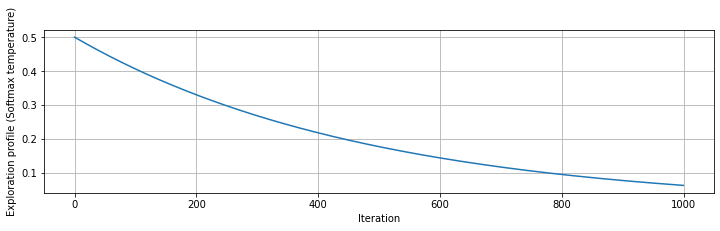

In [9]:
### Define exploration profile
def get_exploration_profile(initial_value=0.5, num_iterations=1000, speed = 3): # speed = speed of convergence, bigger is faster to reach 0
    if initial_value < 0:
        raise Exception('The initial value must be > 0')
    if initial_value > 1:
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * speed) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    else :
        exp_decay = np.exp(np.log(initial_value) / num_iterations * speed)
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    return exploration_profile

exploration_profile = get_exploration_profile()

### Plot exploration profile
plt.figure(figsize=(12,3))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment (CartPole-v1)

In [10]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
# state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n  #

if colab:
  env = wrap_env(env, video_callable=lambda episode_id: True)

In [11]:
#function to get the frame
def get_frame(env, prev_frame, resize=(32,32), device=device, plot=False):
    # Get the current frame 
    frame = env.render(mode='rgb_array')
    pos = env.state[0] #-2.4 to 2.4 in the frame
    c = round(pos*300/2.4 + 300) #center of the cart
    #convert to grayscale
    frame = np.mean(frame, axis=2)
    original_frame = frame
    #convert to binary
    frame[frame < 255] = 0
    frame = frame / 255
    frame = (1 - frame) 
    frame[frame==0] = 1/3
    frame[frame==1] = 2/3    

    if prev_frame is not None:
        diff = 2*frame - prev_frame
    else :
        diff = frame / 2

    prev_frame = frame

    #draw a small square in the absolute middle of diff
    diff[150:170,270:274] = 0.1
    diff[150:170,326:330] = 0.9
    
    if c < 64 or c > (600-64): #out of frame
        diff = np.zeros((300,300))
    else:
        diff = diff[150:300, (c-64):(c+64)]

    diff = cv2.resize(diff, resize, interpolation=cv2.INTER_CUBIC)
    diff = diff[np.newaxis, :]

    if plot and not colab:
        #show diff with opencv
        cv2.imshow('diff', diff[0])
        #cv2.imshow('prev_frame',prev_frame)
        cv2.waitKey(1)
    
    return diff, prev_frame

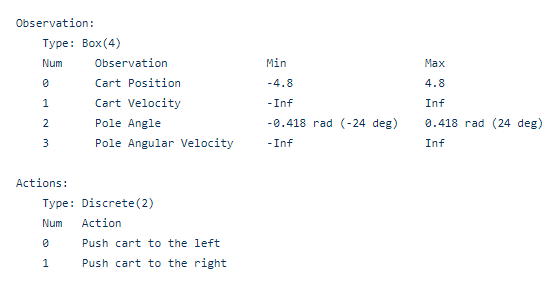

# Network update

In [12]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

x,y = 32,32 #32, 16
state_space_dim = x * y #the image is 32*16

### PARAMETERS
gamma = 0.95   #0.97 gamma parameter for the long term reward #0.99999 # 0.9
replay_memory_capacity = 10000   #10000 Replay memory capacity #10000 # 5000
lr = 3e-2   #1e-2 Optimizer learning rate #1e-2 # 0.12
target_net_update_steps = 5   #10 Number of episodes to wait before updating the target network #10 # 8
batch_size = 128   #128 Number of samples to take from the replay memory for each update #256 # 256
bad_state_penalty = 0   #0 Penalty to the reward when we are in a bad state (in this case when the pole falls down)  #0 # 0
min_samples_for_training = 1000   #1000 Minimum samples in the replay memory to enable the training #1000 # 500
use_epsilon_greedy = False   #False Use epsilon greedy exploration or not #True # False
#set up exploration profile for softmax
initial_value = 5 #5 Initial temperature/epsilon value for the exploration profile #0.5 # 5
num_iterations = 1000 # Number of episodes 1000, #300 # 120
convergence_speed = 6 #6 Speed of convergence of the exploration profile # 1 # 0.8
exploration_profile = get_exploration_profile(initial_value, num_iterations, speed = convergence_speed)

In [13]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity, x=x, y=y)

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim +4).to(device) #+4 because we want to use the state to finetune the network

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim+4).to(device) #+4 because we want to use the state to finetune the network
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

losses, dyn_losses, scores = [],[],[]

In [14]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
  # Sample the data from the replay memory
  states, actions, rewards, non_final_next_states, non_final_mask, dyn = replay_mem.sample(batch_size)


  # Compute all the Q values (forward pass)
  policy_net.train()
  out = policy_net(states)
  q_values = out[:,:action_space_dim]
  dyn_pred = out[:,action_space_dim:]

  dyn_loss_fn = nn.MSELoss()
  dyn_loss = 8.0*dyn_loss_fn(dyn_pred, dyn) #dyn_pred is the predicted dynamics, dyn is the actual dynamics
  #print(f'Dyn loss: {dyn_loss}')

  # Select the proper Q value for the corresponding action taken Q(s_t, a)
  state_action_values = q_values.gather(1, actions.unsqueeze(1))

  # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
  with torch.no_grad():
    target_net.eval()
    out = target_net(non_final_next_states)
    q_values_target = out[:,:action_space_dim]
  next_state_max_q_values = torch.zeros(batch_size, device=device)
  next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

  # Compute the expected Q values
  expected_state_action_values = rewards + (next_state_max_q_values * gamma)
  expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

  # Compute the Huber loss
  loss = loss_fn(state_action_values, expected_state_action_values)

  # Optimize the model
  optimizer.zero_grad()
  loss.backward(retain_graph=True)
  dyn_loss.backward() #backpropagate the dynamics loss
  # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
  nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
  optimizer.step()
  return loss.item(), dyn_loss.item()

In [15]:
if not laod_good_model: #TRAIN
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    # This is for creating the output video in Colab, not required outside Colab
    if colab:
        env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    good_scores_counter = 0

    #list of losses and scores
    for episode_num, tau in enumerate(tqdm(exploration_profile)):
        if use_epsilon_greedy:
            epsilon = tau

        # Reset the environment and get the initial state
        dyn = env.reset()
        state, prev_frame = get_frame(env, None, resize=(x,y))
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        tot_reward = 0

        # Go on until the pole falls off
        episode_loss = []
        episode_dyn_loss = []
        while not done:
            # Choose the action following the policy
            action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon) if use_epsilon_greedy else choose_action_softmax(policy_net, state, temperature=tau)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            dyn, reward, done, info = env.step(action)
            next_state, prev_frame = get_frame(env, prev_frame, resize=(x,y), plot=True)

            #penalty based on the cart being off the screen
            c = env.state[0]*300/2.4 + 300
            if c < 64 or c > (600-64):
                reward -= 100
            
            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1.0
            reward = reward - pos_weight * np.abs(dyn[0]) 

            #linear penalty for the angle
            angle_weight = 4.0
            reward = reward - angle_weight * np.abs(dyn[2])

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += bad_state_penalty
                next_state = None

            tot_reward += reward

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward, dyn)

            # # lower learning rate after a certain number of steps, important if the learning rate is very aggressive
            # # in the early stages of the training 
            # if episode_num > 120:
            #     for param_group in optimizer.param_groups:
            #         param_group['lr'] = 2e-3


            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                loss, dyn_loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
                episode_loss.append(loss)
                episode_dyn_loss.append(dyn_loss)

                
            # Visually render the environment (disable to speed up the training)
            if not colab and show_render:
                env.render()

            # Set the current state for the next iteration
            state = next_state
        #end of while loop

        #get episode loss
        average_episode_loss = np.mean(episode_loss)
        losses.append(average_episode_loss)
        average_episode_dyn_loss = np.mean(episode_dyn_loss)
        dyn_losses.append(average_episode_dyn_loss)
        #get episode score
        scores.append(score)

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            #print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # #tests
        # if score > 300:
        #   optimizer = torch.optim.SGD(policy_net.parameters(), lr=1e-2) ###############################################################################
        #   if score > 400:
        #     optimizer = torch.optim.SGD(policy_net.parameters(), lr=5e-3) ###############################################################################
        # if score < 100:
        #     optimizer = torch.optim.SGD(policy_net.parameters(), lr=3e-2)

        if episode_num > 0.6*num_iterations:
            break 
        #Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temp/epsilon: {tau:.4f}, Loss: {average_episode_loss:.2f} - Dyn Loss: {average_episode_dyn_loss:.2f} - Tot Reward: {tot_reward:.2f}")  
    env.close()


    #save the model
    torch.save(policy_net.state_dict(), f'training/cartpole_policy_net_{num_iterations}.pt')
    #save scores and losses
    np.save(f'training/cartpole_scores_{num_iterations}.npy', scores)
    np.save(f'training/cartpole_losses_{num_iterations}.npy', losses)
    np.save(f'training/cartpole_dyn_losses_{num_iterations}.npy', dyn_losses)

else: #LOAD MODEL
    #load the model
    policy_net.load_state_dict(torch.load(f'training/cartpole_policy_net_{num_iterations}.pt'))
    target_net.load_state_dict(torch.load(f'training/cartpole_policy_net_{num_iterations}.pt'))
    #load scores and losses
    scores = np.load(f'training/cartpole_scores_{num_iterations}.npy')
    losses = np.load(f'training/cartpole_losses_{num_iterations}.npy')
    dyn_losses = np.load(f'training/cartpole_dyn_losses_{num_iterations}.npy')


In [16]:
# Display the videos, not required outside Colab
if colab and show_video:
    show_videos()

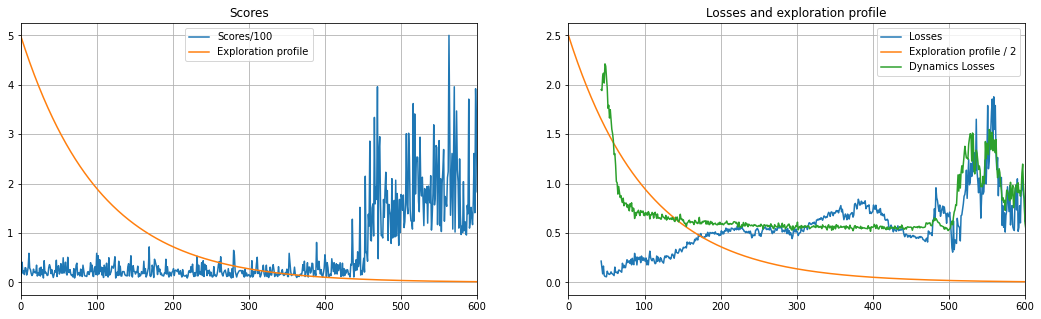

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
#plot scores and losses
fig = plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(scores/100, label='Scores/100')
plt.title('Scores')
plt.plot(exploration_profile, label='Exploration profile')
plt.xlim(0, 600)
# plt.ylim(0, 1.8)
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(losses, label='Losses')
plt.plot(np.array(exploration_profile)/2, label='Exploration profile / 2')
plt.plot(dyn_losses, label='Dynamics Losses')
plt.title('Losses and exploration profile')
plt.xlim(0, 600)
# plt.ylim(0,0.2)
plt.legend()
plt.grid()
plt.show()

#save fig
fig.savefig(f'good_models/cartpole_pixels_scores_losses_{num_iterations}.eps', format='eps', dpi=1000, bbox_inches='tight')

Adding an exploration profile makes the loss go down, however the score goes down with the loss too

# Final test

In [18]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)
if colab:
  env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode    

final_score = []
for i in range(10):    
    if use_epsilon_greedy:
        epsilon = tau

    # Reset the environment and get the initial state
    _ = env.reset()
    state, prev_frame = get_frame(env, None, resize=(x,y))
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    episode_loss = []
    while not done:
        # Choose the action following the policy
        action, q_values = choose_action_epsilon_greedy(policy_net, state, 0) if use_epsilon_greedy else choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        _, reward, done, _ = env.step(action)
        score += reward
        next_state, prev_frame = get_frame(env, prev_frame, resize=(x,y), plot=True)
        state = next_state
    final_score.append(score)
env.close()

print(f"AVERAGE SCORE: {np.mean(final_score)}")

AVERAGE SCORE: 454.3


In [19]:
#let an agent play for a few episodes   
#doesn't work in colab, but works in local
if not colab:
    env = gym.make('CartPole-v1')
    #env.seed(42)

    show_render = True

    scores = []
    # Reset the environment and get the initial state
    _ = env.reset()
    state, prev_frame = get_frame(env, None, device=device, resize=(x,y))
    # Reset the score. The final score will be the total amount of steps before the pole falls
    # Go on
    for i in range(1000): #let it go
        # Choose the best action (temperature 0)
        action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=0) if use_epsilon_greedy else choose_action_softmax(policy_net, state, temperature=0) 
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        _, reward, done, info = env.step(action)
        state, prev_frame = get_frame(env, prev_frame, device=device, resize=(x,y), plot=True)

    env.close()

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/gym/envs/classic_control/cartpole.py:151: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


In [20]:
# Display the videos, not required outside Colab
if colab: 
    show_videos()